# Mini Projeto 3

## implementação de uma MLP usando Pytorch

Neste projeto, implementei uma Multi-Layer Perceptron (MLP) usando PyTorch para classificar a base de dados MNIST.

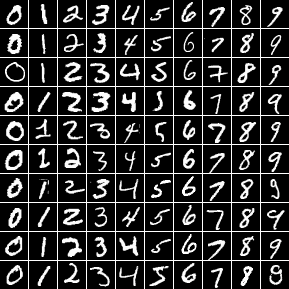

ImpoImportando todas as bibliotecas e a base de dados.

In [110]:
from torchvision import datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [111]:
# Baixar o conjunto de treinamento MNIST, nesse poonto não estou usando nenhuma transformação
batch_size = 128 
base_treinamento = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
base_test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), batch_size=batch_size,download=True)

TypeError: MNIST.__init__() got an unexpected keyword argument 'batch_size'

In [ ]:
# Carrega todos os dados
treinamento_img = torch.utils.data.DataLoader(dataset=base_treinamento, shuffle=True)
teste_img = torch.utils.data.DataLoader(dataset=base_test, batch_size=batch_size, shuffle=False)

Definição do MLP em Pytorch

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Implementação do modelo base de acordo com a solicitação

In [ ]:
#Dados da MLP "Direto do classroom"

input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 500  # Número de neurônios na camada oculta
output_size = 5  # Número de saidas possiveis

num_epochs = 5
learning_rate = 0.001

# Definição do modelo
rede = MLP(input_size, hidden_size, output_size)

1. Inicializando o função de otimização (parametros passados no classroom)
2. Iniciando a GPU (para esse caso vou inicia-la apenas se disponivel no PC)

In [ ]:
# Inicializando o atimizador

otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate)

PC_Processo = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda ativa GPU
rede.to(PC_Processo) # GPU se disponivel é ativada aqui

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

# calculadora de acuracia

In [ ]:
def calcular_acuracia(model, data_loader, PC_Processo):
    model.eval()
    corretos = 0
    total = 0
    with torch.no_grad():
        for imagens, rotulos in data_loader:
            imagens = imagens.view(-1, 28*28).to(PC_Processo)
            rotulos = rotulos.to(PC_Processo)
            saidas = model(imagens)
            _, previstos = torch.max(saidas.data, 1)
            total += rotulos.size(0)
            corretos += (previstos == rotulos).sum().item()
    return (corretos / total) * 100  # Multiplicando por 100 para obter a porcentagem

# chegou a hora de testar o modelo na tentativa de receber dados
## para assim ver os resultados e desse modo aplicar possiveis mudanças

In [ ]:
def treinar_e_avaliar(model, treinamento_loader, teste_loader, otimizador, num_epochs, PC_Processo): # função que calcula e treina minha IA (serve para facilitar minha vida em seguida)
    acuracias = []
    criterio = nn.CrossEntropyLoss()
    # Avaliação inicial
    acuracia_inicial = calcular_acuracia(model, teste_loader, PC_Processo)
    acuracias.append(acuracia_inicial)
    print(f"Acurácia inicial: {acuracia_inicial:.4f}")

    # Loop de treinamento
    for epoch in range(num_epochs):
        for i, (imagens, rotulos) in enumerate(treinamento_loader):
            imagens = imagens.view(-1, 28*28).to(PC_Processo)
            rotulos = rotulos.to(PC_Processo)

            # Forward pass
            saidas = model(imagens)
            perda = criterio(saidas, rotulos)

            # Backward pass e otimização
            otimizador.zero_grad()
            perda.backward()
            otimizador.step()

        # Avaliação no conjunto de teste (ou validação) ao final de cada época
        acuracia_epoca = calcular_acuracia(model, teste_loader, PC_Processo)
        acuracias.append(acuracia_epoca)

        # Imprimindo informações
        print(f'Época [{epoch+1}/{num_epochs}], Acurácia de Teste: {acuracia_epoca:.4f}')

    return acuracias

In [ ]:
# Exemplo de uso
acuracias_treinamento = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)
valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)

Acurácia inicial: 9.6800
Época [1/5], Acurácia de Teste: 91.9200
Época [2/5], Acurácia de Teste: 93.6400
Época [3/5], Acurácia de Teste: 94.5900
Época [4/5], Acurácia de Teste: 95.2200
Época [5/5], Acurácia de Teste: 95.8600


Plot dos resultados

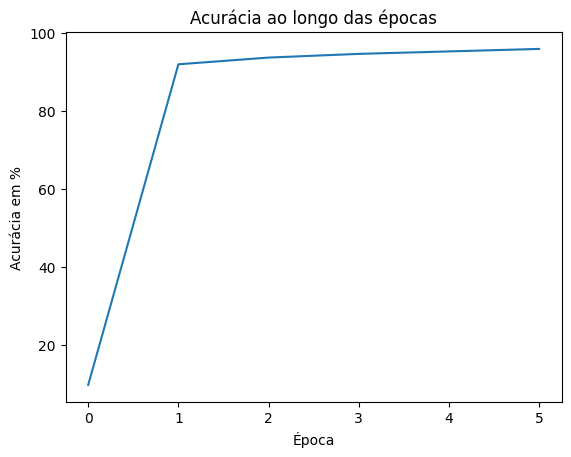

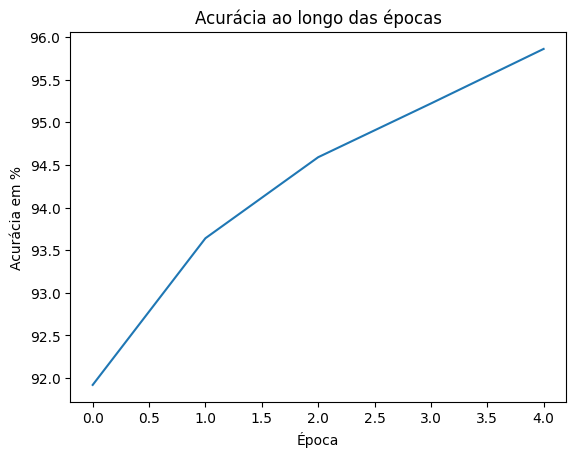

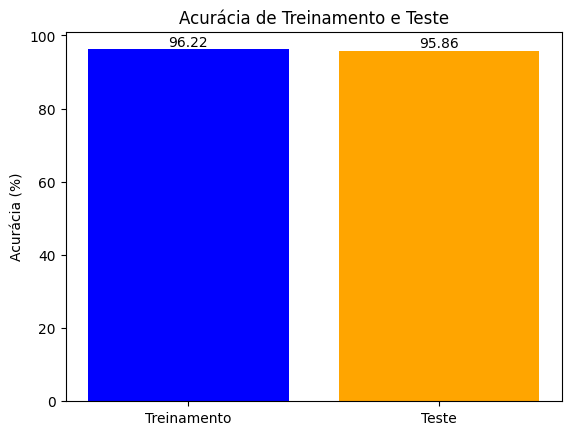

[9.68, 91.92, 93.64, 94.59, 95.22, 95.86]
[96.22333333333334, 95.86]


In [ ]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

print(acuracias_treinamento)
print([valor_treino, valor_teste])


Dado o resultado anterior percebi que que logo após a primeira interação o mesmo esta demorando muito para chegar ao melhor resultado possivel, logo resolvi almenatr o LR na tentativa de acelerar o processo

In [ ]:
# Novos dados
input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 258  # Número de neurônios na camada oculta
output_size = 10  # Número de saídas possíveis

num_epochs = 10
batch_size = 128 
learning_rate = 0.005

rede = MLP(input_size, hidden_size, output_size)
otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate) # atualizando o novo LR
acuracias_treinamento2 = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)

valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)


Acurácia inicial: 11.9700
Época [1/5], Acurácia de Teste: 95.6000
Época [2/5], Acurácia de Teste: 96.5200
Época [3/5], Acurácia de Teste: 97.6100
Época [4/5], Acurácia de Teste: 97.3200
Época [5/5], Acurácia de Teste: 97.7800


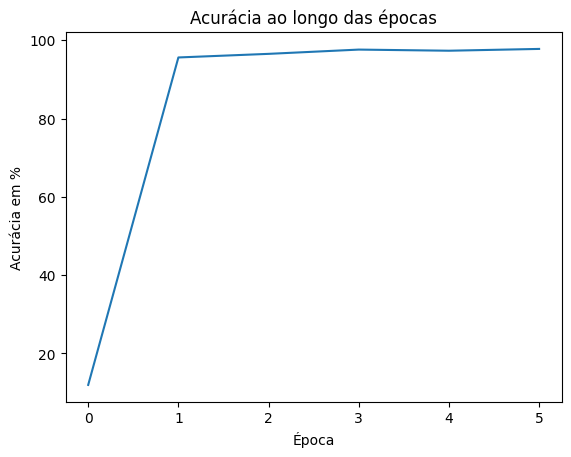

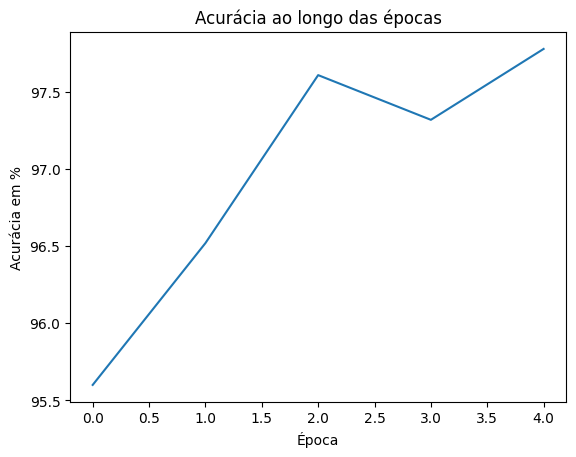

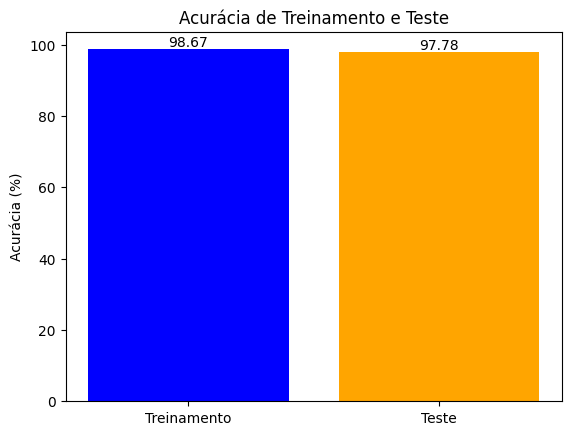

In [ ]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento2[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento2[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()


Outra coisa notada é a demora no período do treinamento, por sua vez posso reduzir o número de neurônios na camada oculta  

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)  # Adicionando dropout
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)  # Adicionando dropout
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

rede = MLP(input_size, hidden_size, output_size)
acuracias_treinamento = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)


In [ ]:
# Novos dados
input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 258  # Número de neurônios na camada oculta
output_size = 10  # Número de saídas possíveis

num_epochs = 10
batch_size = 128 
learning_rate = 0.005

rede = MLP(input_size, hidden_size, output_size)
otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate) # atualizando o novo LR
acuracias_treinamento2 = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)

valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)


In [ ]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento2[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento2[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()
